In [1]:
from functools import partial

import equinox as eqx
from jax import jacfwd
from jax import numpy as np
from jax import vmap
from jax.scipy.stats import norm

from ai.diffusion.score_models.models import GaussianModel, MixtureGaussian

In [2]:
from jax import random
from inspect import getsource
from matplotlib import pyplot as plt
import jax


key = random.PRNGKey(44)

true_mu = 3.0
true_sigma = 1.0

data = random.normal(key, shape=(1000, 1)) * true_sigma + true_mu
data[0:5]  # showing just the first 10 samples drawn

Array([[0.8219464],
       [3.8602278],
       [1.4089172],
       [3.4423368],
       [3.2420166]], dtype=float32)

In [3]:
gaussian_model = GaussianModel(0.0,np.log(1.0))
(
    gaussian_model(-3.0),
    gaussian_model(0.0),
    gaussian_model(3.0),
)

(Array(3., dtype=float32, weak_type=True),
 Array(-0., dtype=float32, weak_type=True),
 Array(-3., dtype=float32, weak_type=True))

In [4]:
from jax import vmap
data_score = vmap(gaussian_model)(data).squeeze()
data_score[0:5]

Array([-0.8219464, -3.8602278, -1.4089172, -3.4423368, -3.2420166],      dtype=float32)

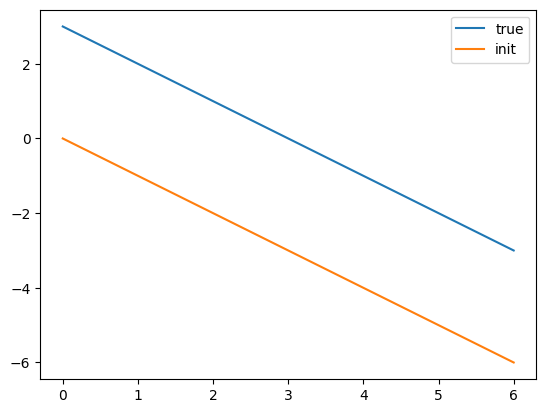

In [5]:
support = np.linspace(0,6,100)
plt.plot(support, vmap(GaussianModel(true_mu,np.log(true_sigma)))(support).squeeze(),label='true')
plt.plot(support, vmap(GaussianModel(0.0,np.log(1.0)))(support).squeeze(),label='init')
plt.legend()

In [6]:
from score_models.training import fit
from score_models.losses import score_matching_loss
import optax

optimizer = optax.adam(learning_rate=5e-3)
updated_model, loss_history = fit(
    gaussian_model, 
    data, 
    score_matching_loss, 
    optimizer, 
    steps=2_000, 
    progress_bar=False
)

/Users/egafni/Library/Caches/pypoetry/virtualenvs/ai-p8EyLVof-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


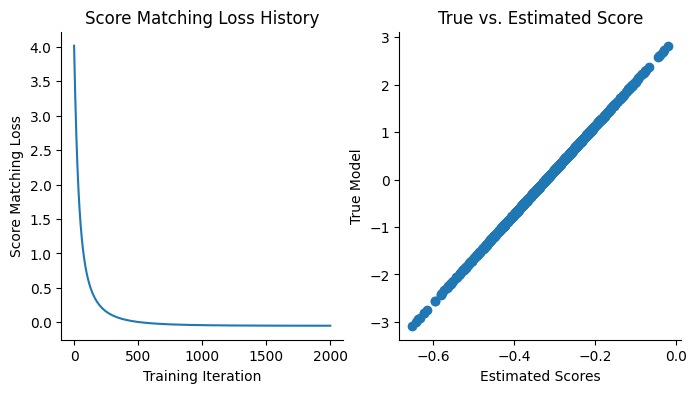

In [7]:
import seaborn as sns
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

plt.sca(axes[0])
plt.plot(loss_history)
plt.xlabel("Training Iteration")
plt.ylabel("Score Matching Loss")
plt.title("Score Matching Loss History")
sns.despine()

plt.sca(axes[1])
true_model_scores = vmap(GaussianModel(true_mu,np.log(true_sigma)))(data).squeeze()
updated_model_scores = vmap(updated_model)(data)
plt.scatter(updated_model_scores.squeeze(), true_model_scores.squeeze())
plt.xlabel("Estimated Scores")
plt.ylabel("True Model")
plt.title("True vs. Estimated Score")
sns.despine()

In [8]:
np.mean(data), np.std(data), updated_model.mu, np.exp(updated_model.log_sigma)

(Array(2.9986677, dtype=float32),
 Array(1.0197434, dtype=float32),
 0.0,
 Array(3.0560646, dtype=float32))

In [9]:
from score_models.models.feedforward import FeedForwardModel1D

from jax import nn 
from score_models import losses

regularized_loss = losses.chain(
    losses.l2_norm, 
    losses.score_matching_loss,
)
ffmodel = FeedForwardModel1D(depth=1, width_size=1024, activation=nn.relu)
optimizer = optax.chain(
    optax.clip(0.01),
    optax.sgd(learning_rate=5e-3),
)
updated_model, history = fit(
    ffmodel,
    data,
    regularized_loss,
    optimizer,
    steps=2_000,
    progress_bar=True,
)

ValueError: mutable default <class 'jaxlib.xla_extension.ArrayImpl'> for field mu is not allowed: use default_factory

In [ ]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

plt.sca(axes[0])
plt.plot(loss_history)
plt.xlabel("Training Iteration")
plt.ylabel("Loss Value")
plt.title("Score Matching Loss History")
sns.despine()

plt.sca(axes[1])
updated_model_scores = vmap(updated_model)(data).squeeze()
plt.scatter(data.squeeze(), true_model_scores, label="True Model Scores")
plt.scatter(data.squeeze(), updated_model_scores, label="Feed Forward Estimate")
plt.xlabel("Support")
plt.ylabel("Score")
plt.title("True vs. Estimated Score")
plt.legend()
sns.despine()